<a href="https://colab.research.google.com/github/davideandres95/ml_comm/blob/main/tut11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial 11

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy import special

### Problem 9.1. (Linear filter recap) 
Consider the filter
$h = (0, 0, 3, 2, 1)$
* 1. Implement a function that realizes the circular convolution $h * x$ for a length $n$
input vector $x$.
* 2. Realize the circular convolution from 1. using an NN with a linear layer provided by
torch.nn.Linear. Verify the correctness of your implementation by comparing
your implementation from 1. for several test sequences $x$.
* 3. Realize the convolution from 1. using an NN with a convolutional layer provided by
torch.nn.Conv1d. Is this convolution circular? Test against 1. and 2. Where
in the output sequence do the sequences differ?

In [ ]:
def filter_circ(signal, h):
    k = len(signal) - len(h) 
    hh = np.pad(h, (int(np.ceil(k/2)),int( np.floor(k/2)))) # zero pad
    filter_fd = np.fft.fft(hh)
    s_fd = np.fft.fft(signal)
    signal_td = np.fft.ifftshift(np.fft.ifft(s_fd * filter_fd))
    return np.real(signal_td)

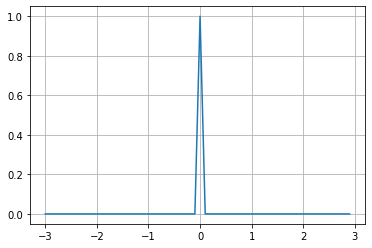

In [ ]:
t = np.arange(-3,3,0.1)
n = len(t)
x = signal.unit_impulse(n, int(n/2))
h = np.array([0,0,3,2,1])
plt.plot(t,x)
plt.grid()
plt.show()

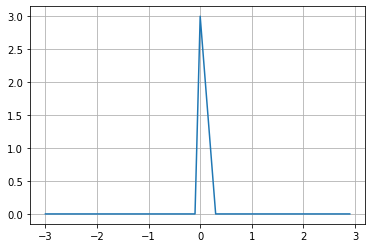

In [ ]:
conv = filter_circ(x, h)
plt.plot(t, conv)
plt.grid()

###### torch.nn.Linear

In [ ]:
import torch
from torch import nn, optim

In [ ]:
def getchunks(x, num_taps=5):
    x = x.reshape(-1, 1)
    chunks = torch.zeros(x.shape[0], num_taps)
    for j in range(num_taps):
        chunks[:, j:j+1] = torch.roll(x, j - num_taps//2)
    return chunks

In [ ]:
class Circ_conv1(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(5, 1, bias=False)
        self.lin1.weight = nn.Parameter(torch.Tensor([0,0,3,2,1]))
        
        

    def forward(self, y):
        return self.lin1(y)

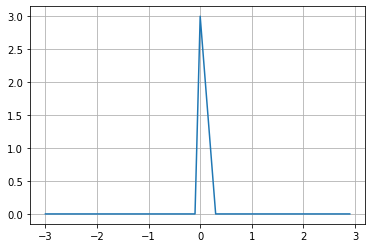

In [ ]:
x_t = torch.tensor(x)
xx = getchunks(x_t)
circ_conv1 = Circ_conv1()
conv1 = circ_conv1(xx)
plt.plot(t, conv1.detach().numpy())
plt.grid()

###### torch.nn.Conv1d

In [ ]:
nn_filter = nn.Conv1d (in_channels=1 ,
                       out_channels=1 ,
                       kernel_size=5,
                       bias=False,
                       padding='same' )
nn_filter.weight = nn.Parameter(torch.tensor([[[ 0.,  0., 3.,  2., 1.]]]))

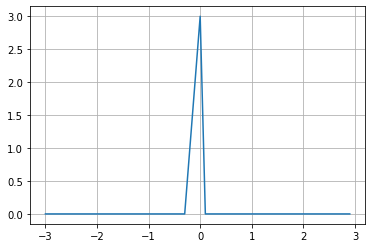

In [ ]:
conv2 = nn_filter(x_t.reshape(1, 1, -1).float())
plt.plot(t, conv2.detach().numpy().reshape(-1,))
plt.grid()

### Problem 9.3. (differential entropy estimation) 
Sample $n = 10 000$ vectors $z_0, z_1, \dots, z_{n-1}$, each with $d$ entries from a zero mean Gaussian density $p_X$ with covariance matrix $\sigma^2 I$, where $I$ is the $d \times d$ identity matrix.
* 1. What is the differential entropy of the $d$-dimensional random vector $X$?


2. Plot the differential entropy for $d = 1, 2, 3, 4$ and $\sigma^2 = 0.1, 0.2, \dots, 1$.
3. Use the differential entropy estimator *mlcomm.estim.differential_entropy_estimator_dD* from https://gitlab.lrz.de/gb/mlcomm to estimate the differential entropy from the sample sequences $z^n$

In [ ]:
# Differential Entropy Estimator
def _d_dimensional_ball_volume(d):
        return np.pi**(d/2)/special.gamma(d/2+1)


def _differential_entropy_dD(x, eps=0.001):
    n, d = x.shape
    x_dist = torch.cdist(x, x, p=2.)
    x_fill = x_dist.clone().fill_diagonal_(9999.99, wrap=False)
    Ri, _ = torch.min(x_fill, dim=1)
    Vd = _d_dimensional_ball_volume(d)
    tmp = torch.log(n * Vd * (Ri**d).reshape(-1, 1) + eps)
    return torch.mean(tmp) + np.euler_gamma

def differential_entropy_dD(x, nperseg=100, eps=0.001):
    n, d = x.shape
    assert n % nperseg == 0
    nseg = n//nperseg
    ys = x.reshape(-1, nperseg, d)
    h = torch.zeros(nseg)
    for j, y in enumerate(ys):
        h[j] = _differential_entropy_dD(y, eps)
    return torch.mean(h)

In [ ]:
def gaussian_entropy(sigma2):
    return 0.5 * np.log(2 * np.pi * sigma2 * np.e)

In [ ]:
sigma2 = np.arange(0.1, 1.0 + 0.1, 0.1)
n = 10_000
ds = [1, 2, 3, 4]

h_actual = []
h_expected = []
for d in ds:
    _h_actual = []
    _h_expected = []
    for s2 in sigma2:
        _h_expected.append(d * gaussian_entropy(s2))
        z = np.sqrt(s2) * np.random.randn(n, d)
        _h_actual.append(differential_entropy_dD(torch.Tensor(z)).numpy())
    h_actual.append(np.array(_h_actual))
    h_expected.append(np.array(_h_expected))

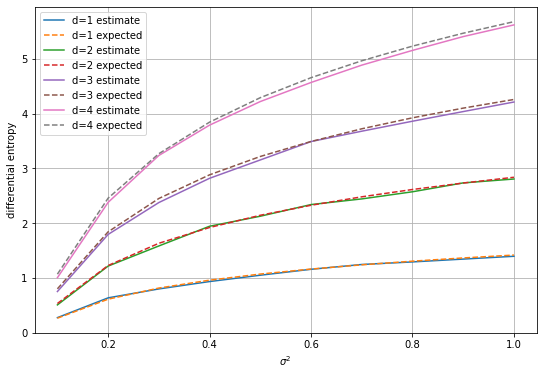

In [ ]:
plt.rcParams['figure.figsize'] = [9, 6]
for d, act, exp in zip(ds, h_actual, h_expected):
    plt.plot(sigma2, act, label=f'd={d} estimate')
    plt.plot(sigma2, exp, linestyle='dashed', label=f'd={d} expected')
plt.grid(which='both')
plt.xlabel(r'$\sigma^2$')
plt.ylabel('differential entropy')
plt.legend()
plt.show()

### Problem 9.4 (fake Gaussian source) 
In this problem, you will implement an NN that
transforms a uniform random variable into fake Gaussian noise.
* 1. Implement a nonlinear NN $f$ with scalar input and scalar output.

As input to this network, sample un from a density $p_U$ that is uniform on $[0, 1]$.  You can use *torch.rand(n, 1)*. 

Plot a histogram of the output $\hat{z}^n = f(u_n)$ of the initialized NN and compare it with the histogram of samples $z^n$ from a zero mean Gaussian density with variance $\sigma^2=1$.

* 2. Train your network using as loss the MSE. Plot the histogram. Can you explain
the trained $f$ mathematically?

In [ ]:
class Noise(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1,100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 50),
            nn.LeakyReLU(),
            nn.Linear(50, 1),
        )
    def forward(self, z):
        return self.model(z)
    
def training(loss_fn, n_epochs=1000, batch_size=1000):
    noise_model = Noise()
    optimizer = optim.Adam(noise_model.parameters())
    for k in range(n_epochs):
        uni_z = torch.rand(batch_size, 1)
        true_z = torch.randn(batch_size, 1)
        z = noise_model(uni_z)
        loss = loss_fn(true_z, z)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if k > 0 and k % 100 == 0:
            print(f'Epoch {k}, loss={loss :.2f}')
            histogram(true_z, z)
    return true_z, z, noise_model

def histogram(expected, actual):
    plt.rcParams['figure.figsize'] = [7, 5]
    exp = expected.detach().numpy().reshape(-1)
    act = actual.detach().numpy().reshape(-1)
    plt.hist(exp, bins=np.arange(-4, 4+0.1, 0.1))
    plt.hist(act, bins=np.arange(-4, 4+0.1, 0.1), alpha=0.5)
    plt.show()

Epoch 100, loss=0.95


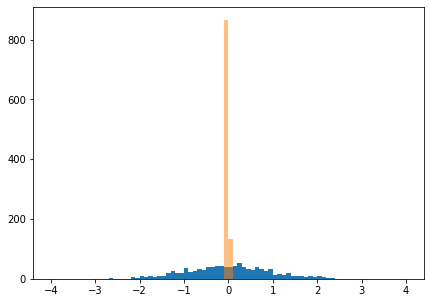

Epoch 200, loss=1.07


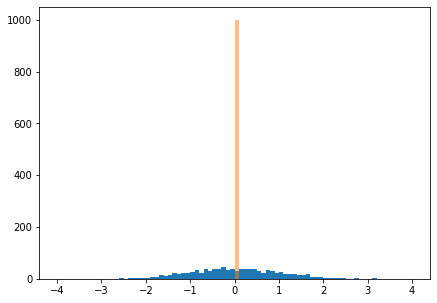

Epoch 300, loss=1.00


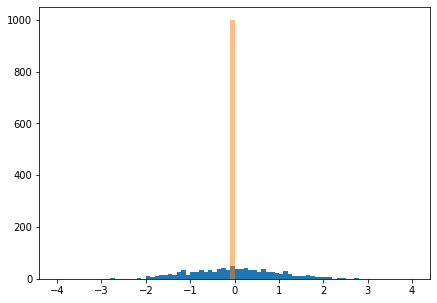

Epoch 400, loss=0.93


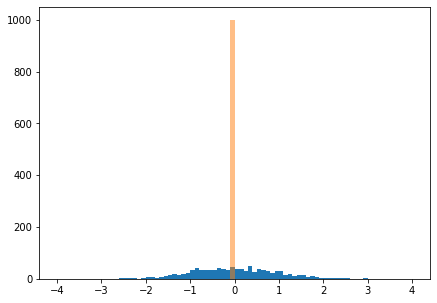

Epoch 500, loss=0.95


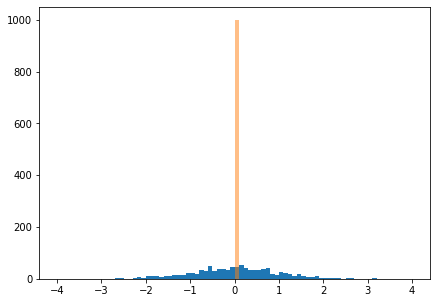

Epoch 600, loss=1.05


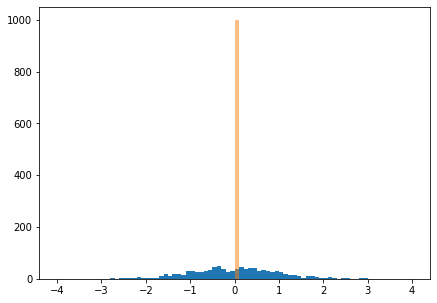

Epoch 700, loss=0.96


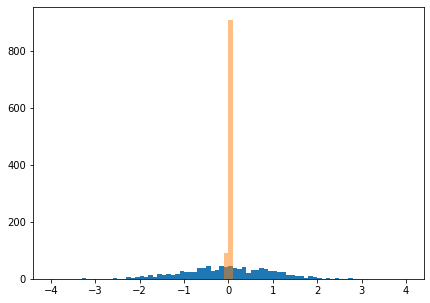

Epoch 800, loss=1.01


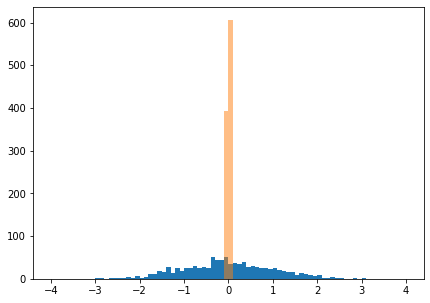

Epoch 900, loss=1.01


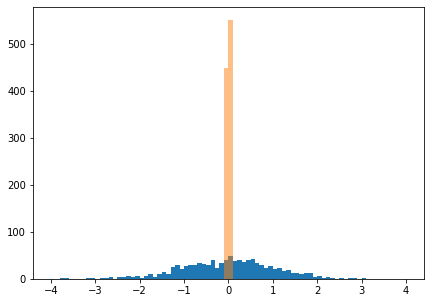

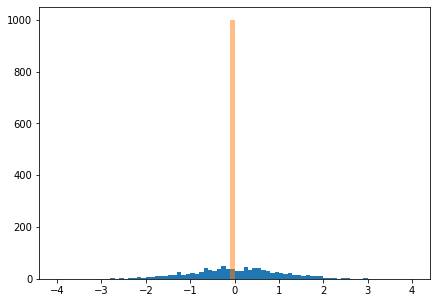

In [ ]:
loss_fn = nn.MSELoss()
true_z, z, _ = training(loss_fn)
histogram(true_z, z)

* 3. To enforce the required mean and variance. Train your network using as loss
$$|E(\hat{Z})|^2 + |E(\hat{Z^2}) - \sigma ^2 |^2$$
In your implementation, replace probabilistic expectation $E(\cdot)$ by empirical expectation.

(You can also try using $ |\cdot| $ instead of  $ |\cdot|^2 $   in the above loss). 

Plot the resulting histogram.

Epoch 100, loss=0.02


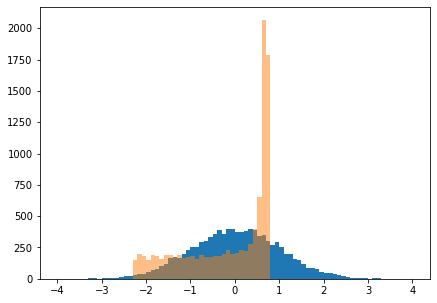

Epoch 200, loss=0.00


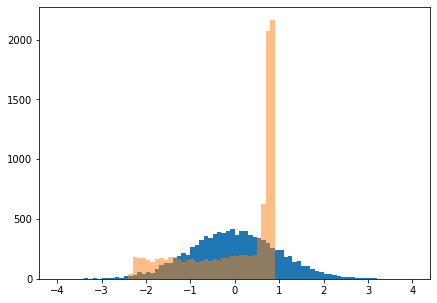

Epoch 300, loss=0.00


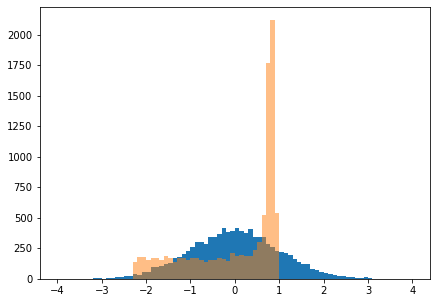

Epoch 400, loss=0.00


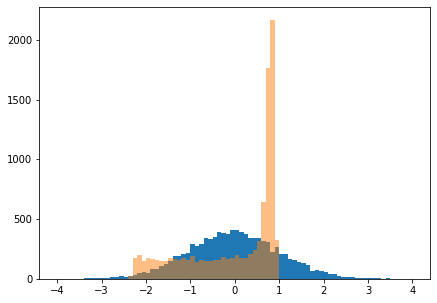

Epoch 500, loss=0.00


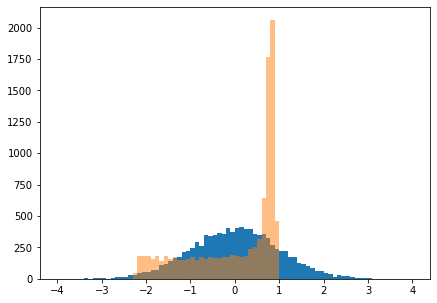

Epoch 600, loss=0.00


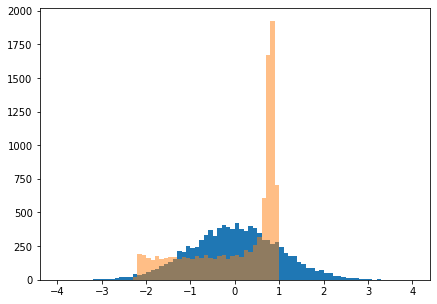

Epoch 700, loss=0.00


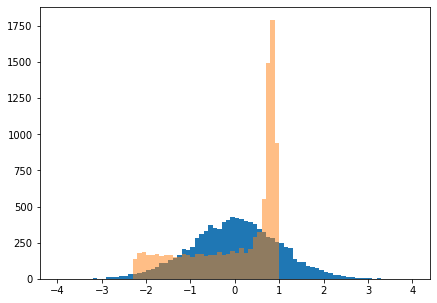

Epoch 800, loss=0.01


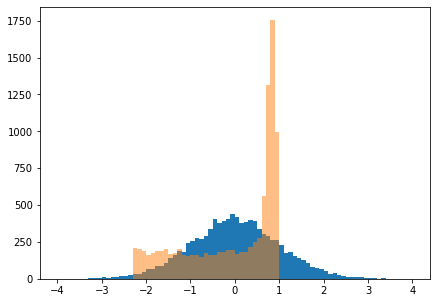

Epoch 900, loss=0.00


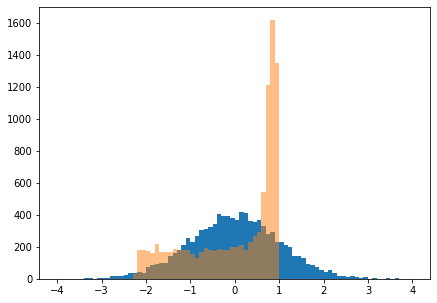

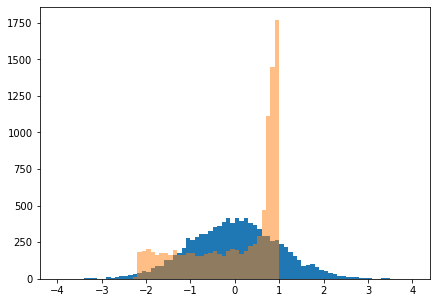

In [ ]:
def loss_fn(expected, actual):
    mu = torch.mean(expected)
    sigma2 = torch.mean((expected - mu)**2)
    return ((torch.mean(actual))**2
            + (torch.mean((actual)**2) - sigma2)**2)

true_z, z, _ = training(loss_fn, n_epochs=1000, batch_size=10000)
histogram(true_z, z)

* 4. Train now your network using the loss (9.15), i.e.,
$$|E(\hat{Z})|^2 + \frac{\log(e)}{2 \sigma^2}E(\hat{Z}^2) - h(\hat{Z})$$
where we have added $|E(\hat{Z})|^2$ to enforce zero mean. 

In your implementation replace probabilistic expectations by empirical expectations and use the differential
entropy estimator from Problem 9.3.3 to estimate $ h(\hat{Z})$.

Epoch 100, loss=-0.77


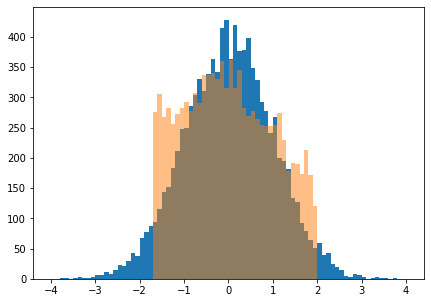

Epoch 200, loss=-0.86


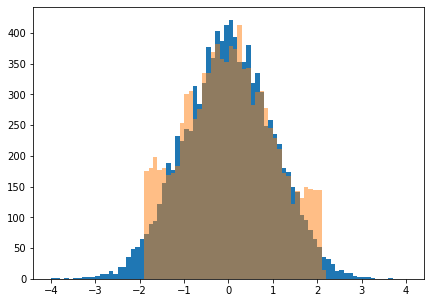

Epoch 300, loss=-0.86


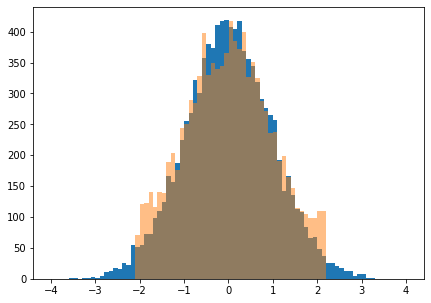

Epoch 400, loss=-0.91


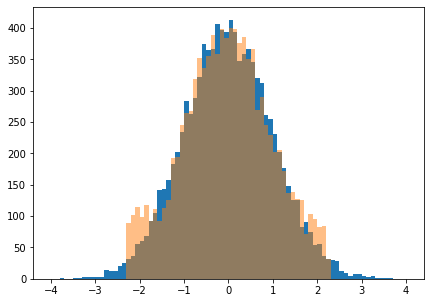

Epoch 500, loss=-0.86


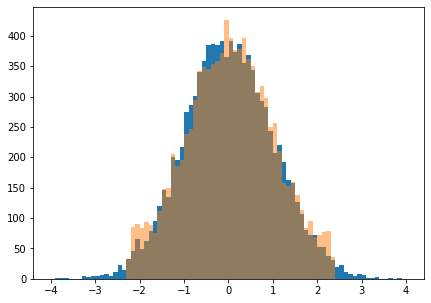

Epoch 600, loss=-0.87


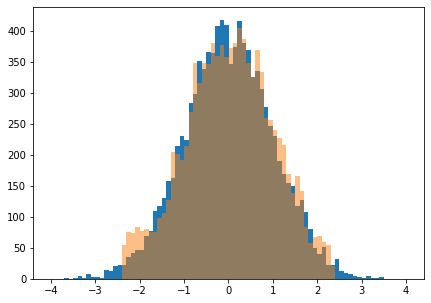

Epoch 700, loss=-0.89


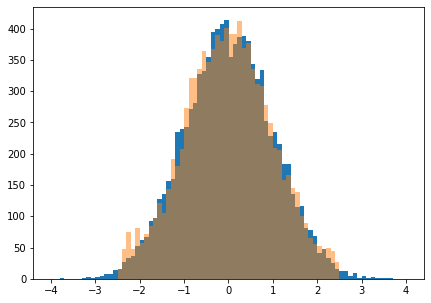

Epoch 800, loss=-0.90


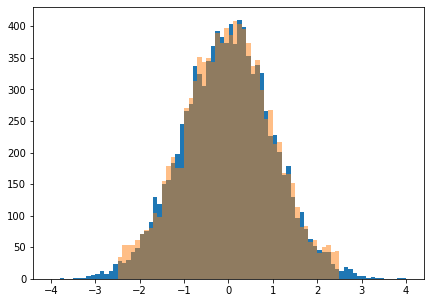

Epoch 900, loss=-0.88


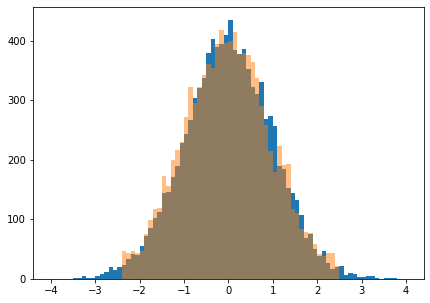

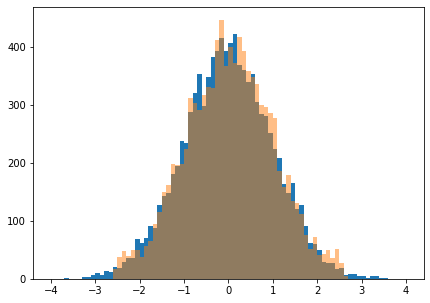

In [ ]:
def loss_fn(expected, actual):
    mu = torch.mean(expected)
    sigma2 = torch.mean((expected - mu)**2)

    return ((torch.mean(actual))**2 
            + np.log(np.e) * 1 / 2 / sigma2 * torch.mean((actual)**2)
            - differential_entropy_dD(actual))

true_z, z, noise_model = training(loss_fn, n_epochs=1000, batch_size=10000)
histogram(true_z, z)

* 5. We now want to assess how good our fake source is. 
To this end, we train a discriminator using the BCE loss on LPRs. The discriminator is a non-linear network with scalar input and scalar output. As we use the BCE on LPRs, the output layer is linear.


 a) Training: We feed the discriminator with sequences $z_n$ from the true source with label $b = 1$, and sequences $\hat{z}_n$ from our fake source with label b = 0.

Denoting the discriminator output by $\ell$, the cost can be calculated by
$$BCE_{log}(b^{2n}, \ell^{2n}) = \frac{1}{2n} \sum_{i=0}^{2n-1} bce_{log}(b_i, \ell_i) = 0.5 \cdot \frac{1}{n} \sum_{i=0}^{n-1} bce_{log}(0,\hat{z}_i) + 0.5 \cdot \frac{1}{n} \sum_{i=0}^{n-1} bce_{log}(1,z_i)  $$

 b) Evaluation: calculate the probability $P_{B|Z}(0|z)$ from the tained discriminator
output and plot $z$ against $P_{B|Z}(0|z)$. For which values of $z$ can the discriminator
not distinguish between true and fake?

 c) Evaluation: estimate $H(B|Z)$ using the trained discriminator. What would
be the value of $H(B|Z)$ for a perfect fake source? How much in bits is our
fake source different from a perfect fake source?

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 10)
        self.act1 = nn.ReLU()
        self.h2 = nn.Linear(10,20)
        self.act2 = nn.ReLU()
        self.h3 = nn.Linear(20,20)
        self.act3 = nn.ReLU()
        self.h4 = nn.Linear(20,1)
        
        
    def forward(self,y):
        y = self.act1(self.h1(y))
        y = self.act2(self.h2(y))
        y = self.act3(self.h3(y))
        return self.h4(y)

In [ ]:
discriminator = Model()
# Loss function
loss_fn = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(discriminator.parameters(), lr=0.1)

In [ ]:
batch_size = 10_000
for j in range(700): 
    true_zz = torch.randn(batch_size, 1)
    zz = torch.rand(batch_size, 1)
    zz = noise_model(zz).detach()
    l1 = discriminator(true_zz)
    l2 = discriminator(zz)
    loss = 0.5*loss_fn(l1, torch.ones(len(l1),1)) + 0.5*loss_fn(l2, torch.zeros(len(l2),1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Printout and visualization
    if j % 100 == 0: 
        print(f'epoch {j}: Loss = {loss.detach().numpy() :.4f}')

epoch 0: Loss = 0.6961
epoch 100: Loss = 0.6931
epoch 200: Loss = 0.6931
epoch 300: Loss = 0.6931
epoch 400: Loss = 0.6931
epoch 500: Loss = 0.6931
epoch 600: Loss = 0.6931


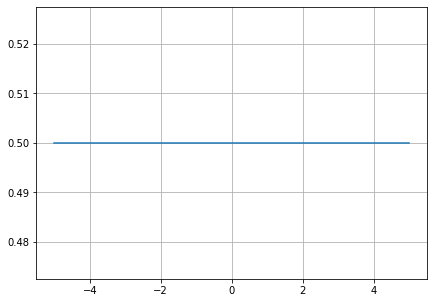

In [ ]:
# Plot
x_plot = np.arange(-5,5+0.1,0.1)
y_plot = discriminator(torch.tensor(x_plot.reshape(-1,1)).float()).detach().numpy()
plt.plot(x_plot, np.e**y_plot/(1+np.e**y_plot))
plt.grid()

In [ ]:
# H(B|Z)
prob1 = l1.detach().numpy() 
prob1 = np.e**prob1/(1+np.e**prob1)
prob2 = l2.detach().numpy() 
prob2 = np.e**prob2/(1+np.e**prob2)
entropy = 0.5 * np.mean(-np.log2(prob1)) + 0.5 * np.mean(-np.log2(prob2))

In [ ]:
print(f'Entropy of a discriminator for a perfect fake source: {-np.log2(0.5)}')
print(f'Entropy of our discriminator: {entropy}')

Entropy of a discriminator for a perfect fake source: 1.0
Entropy of our discriminator: 0.9999998807907104
